In [1]:
# Import dependencies
import pandas as pd
from pandas import Series, DataFrame
from datetime import datetime
import datetime as dt
import time
import requests
import json
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import locale
locale.setlocale(locale.LC_ALL,'')

from config import apikey

### *Using Alpha Vantange API - Find Data for SPY (S&P 500)*

In [2]:
data_frequency = 'MONTHLY'
SPY_ticker = 'SPY'

SPY_url = f'https://www.alphavantage.co/query?function=TIME_SERIES_{data_frequency}&symbol={SPY_ticker}&apikey=' + apikey
SPY_response = requests.get(SPY_url).json()

In [3]:
SPY_dates = []
SPY_close = []

for dates in SPY_response['Monthly Time Series']:
        SPY_close.append(SPY_response['Monthly Time Series'][dates]['4. close'])
        if dates not in SPY_dates:
            SPY_dates.append(dates)


SPY_data = pd.DataFrame({'Date': SPY_dates, 'SPY_Close': SPY_close})
SPY_data            

,Date,SPY_Close
0,2020-01-03,322.4100
1,2019-12-31,321.8600
2,2019-11-29,314.3100
3,2019-10-31,303.3300
4,2019-09-30,296.7700
...,...,...
235,2000-06-30,145.2812
236,2000-05-31,142.8125
237,2000-04-28,145.0937
238,2000-03-31,150.3750


### *Using Alpha Vantange API - Find data for VBMFX (Total Bond)*

In [4]:
VBMFX_ticker = 'VBMFX'

VBMFX_url = f'https://www.alphavantage.co/query?function=TIME_SERIES_{data_frequency}&symbol={VBMFX_ticker}&apikey=' + apikey
VBMFX_response = requests.get(VBMFX_url).json()

In [5]:
VBMFX_dates = []
VBMFX_close = []

for dates in VBMFX_response['Monthly Time Series']:
        VBMFX_close.append(VBMFX_response['Monthly Time Series'][dates]['4. close'])
        if dates not in VBMFX_dates:
            VBMFX_dates.append(dates)


VBMFX_data = pd.DataFrame({'Date': VBMFX_dates, 'VBMFX_Close': VBMFX_close})
VBMFX_data

,Date,VBMFX_Close
0,2020-01-03,11.1200
1,2019-12-31,11.0500
2,2019-11-29,11.0900
3,2019-10-31,11.1200
4,2019-09-30,11.1200
...,...,...
235,2000-06-30,9.6100
236,2000-05-31,9.4600
237,2000-04-28,9.5300
238,2000-03-31,9.6300


### *Merge SPY and VBMFX DataFrames*

In [26]:
data = SPY_data.merge(VBMFX_data, on='Date')

# Change all column dtypes to datetime or float as appropriate
data['Date'] = pd.to_datetime(data['Date'])
data['SPY_Close'] = pd.to_numeric(data['SPY_Close'])
data['VBMFX_Close'] = pd.to_numeric(data['VBMFX_Close'])

data = data.set_index('Date')

data.dtypes

SPY_Close      float64
VBMFX_Close    float64
dtype: object

In [27]:
data

,SPY_Close,VBMFX_Close
Date,,
2020-01-03,322.4100,11.12
2019-12-31,321.8600,11.05
2019-11-29,314.3100,11.09
2019-10-31,303.3300,11.12
2019-09-30,296.7700,11.12
...,...,...
2000-06-30,145.2812,9.61
2000-05-31,142.8125,9.46
2000-04-28,145.0937,9.53


### *Calculate 12-Month Percentage Change*

In [25]:
data_12M_Return = data.pct_change(12)
data_12M_Return = data_12M_Return.dropna()

# Update columns to appropriate names
data_12M_Return = data_12M_Return.rename(columns={'SPY_Close': 'SPY_Return','VBMFX_Close': 'VBMFX_Return'})

data_12M_Return

,SPY_Return,VBMFX_Return
Date,,
2019-01-31,-0.162774,-0.053058
2018-12-31,-0.223513,-0.054299
2018-11-30,-0.123000,-0.072137
2018-10-31,-0.107803,-0.077338
2018-09-28,-0.020386,-0.068345
...,...,...
2000-06-30,0.185002,-0.042829
2000-05-31,0.133433,-0.057769
2000-04-28,0.161679,-0.048902


### *Calculate 12-Month Rolling Returns for Five New Portfolios*

#### The weight for the portfolios are:
    * Very Aggressive: 100% Stock (SPY)
    * Aggeressive: 80% SPY and 20% Bonds (VBMFX)
    * Moderate: 50% SPY and 50% VBMFX
    * Conservative: 20% SPY and 80% VBMFX
    * Very Conservative: 100% VBMFX

In [15]:
data_12M_Return['Very_Aggressive'] = data_12M_Return.SPY_Return

data_12M_Return['Aggressive'] = .8*data_12M_Return.SPY_Return + .2* data_12M_Return.VBMFX_Return

data_12M_Return['Moderate'] = .5*data_12M_Return.SPY_Return + .5* data_12M_Return.VBMFX_Return

data_12M_Return['Conservative'] = .2*data_12M_Return.SPY_Return + .8* data_12M_Return.VBMFX_Return

data_12M_Return['Very_Conservative'] =  data_12M_Return.VBMFX_Return

data_12M_Return

,SPY_Return,VBMFX_Return,Very_Aggressive,Aggressive,Moderate,Conservative,Very_Conservative
Date,,,,,,,
2019-01-31,-0.162774,-0.053058,-0.162774,-0.140831,-0.107916,-0.075001,-0.053058
2018-12-31,-0.223513,-0.054299,-0.223513,-0.189670,-0.138906,-0.088142,-0.054299
2018-11-30,-0.123000,-0.072137,-0.123000,-0.112827,-0.097568,-0.082310,-0.072137
2018-10-31,-0.107803,-0.077338,-0.107803,-0.101710,-0.092571,-0.083431,-0.077338
2018-09-28,-0.020386,-0.068345,-0.020386,-0.029978,-0.044366,-0.058753,-0.068345
...,...,...,...,...,...,...,...
2000-06-30,0.185002,-0.042829,0.185002,0.139436,0.071086,0.002737,-0.042829
2000-05-31,0.133433,-0.057769,0.133433,0.095192,0.037832,-0.019529,-0.057769
2000-04-28,0.161679,-0.048902,0.161679,0.119563,0.056388,-0.006786,-0.048902


### *Create Summary Statics for the Five Portfolios*

Mean and STD will be used for the model calculations

In [24]:
data_12M_Return.describe()

,SPY_Return,VBMFX_Return,Very_Aggressive,Aggressive,Moderate,Conservative,Very_Conservative
count,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000
mean,-0.022980,-0.005816,-0.022980,-0.019548,-0.014398,-0.009249,-0.005816
std,0.188595,0.029357,0.188595,0.150488,0.094185,0.042694,0.029357
min,-0.332400,-0.083254,-0.332400,-0.275089,-0.189123,-0.103156,-0.083254
25%,-0.129239,-0.023485,-0.129239,-0.102962,-0.066762,-0.035008,-0.023485
50%,-0.086368,-0.005666,-0.086368,-0.069211,-0.043769,-0.016530,-0.005666
75%,0.011145,0.013501,0.011145,0.008911,0.005796,0.008571,0.013501
max,0.810091,0.059546,0.810091,0.653678,0.419059,0.184441,0.059546


### *Below Calculates the Ending Portfolio Value Based on:*
    * Initial investment 
    * Additions
    * Time horizon
    * Expected rate of returns
##### This will NOT be used as the market returns are never uniform

In [22]:
pv = 10000
time_horizon = 30
i = 0.0867
additions = 10000

for year in range(time_horizon):
    ending = pv * (1+i) + additions
    print(locale.currency(ending, grouping=True))
    pv = ending

$20,867.00
$32,676.17
$45,509.19
$59,454.84
$74,609.57
$91,078.22
$108,974.71
$128,422.81
$149,557.07
$172,523.67
$197,481.47
$224,603.12
$254,076.21
$286,104.61
$320,909.88
$358,732.77
$399,834.90
$444,500.59
$493,038.79
$545,785.25
$603,104.83
$665,394.02
$733,083.68
$806,642.04
$886,577.90
$973,444.21
$1,067,841.82
$1,170,423.70
$1,281,899.44
$1,403,040.12


### *Below Calculates the Ending Portfolio Value Based on:*
    * Initial investment 
    * Additions
    * Time horizon
    * Expected rate of returns
    * AND Standard Deviation
##### These calculations are more likely to happen, but multiple simulations will be performed

In [23]:
pv = 10000
expected_return = .0867
volatility = .17
time_horizon =30
annual_addition = 10000

print("\tReturn", "\t\tEnding Value".rjust(18))
for year in range(time_horizon):
    market_return = np.random.normal(expected_return, volatility)
    fv = pv * (1 + market_return) + annual_addition
    print("\t{}".ljust(10).format(round(market_return,4)), "\t{}".rjust(10).format(locale.currency(fv, grouping=True)))
    pv = fv

	Return     		Ending Value
	-0.1687               	$18,313.35
	0.1662               	$31,356.84
	0.4641               	$55,909.43
	0.1667               	$75,226.82
	-0.1862               	$71,219.65
	0.1353               	$90,856.16
	0.2387               	$122,545.97
	-0.003               	$132,182.75
	0.0902               	$154,111.16
	-0.2538               	$124,998.98
	0.0944               	$146,794.55
	0.1371               	$176,914.51
	0.1908               	$220,664.18
	0.0504               	$241,777.91
	-0.1496               	$215,611.84
	-0.0393               	$217,138.13
	0.0316               	$234,003.45
	0.2355               	$299,103.31
	-0.1566               	$262,274.89
	0.0297               	$280,070.65
	0.0833               	$313,406.04
	0.354               	$434,360.53
	-0.1372               	$384,783.91
	0.2361               	$485,640.88
	-0.284               	$357,726.06
	0.054               	$387,042.52
	0.1014               	$436,307.87
	0.066               	$475,09

#### *For the web app version, PV, annual_investment and time_horizon will be grabbed from user input.*
#### *Expected_return and volatility will be grabbed from the portfolio selected.*

In [48]:
sim = DataFrame() #<------ IS THERE A REASON TO USE DataFrame() INSTEAD OF pd.DataFrame()?
iterations = 100

for x in range(iterations):
    
    expected_return = .0867 #Value based on selection
    volatility = .17 #Value based on selection
    time_horizon = 30 #Input Value
    pv = 10000 #Input Value
    annual_investment = 10000 #Input Value
    stream = []
    
    for i in range(time_horizon):
        
        end = round(pv * (1 + np.random.normal(expected_return,volatility)) + annual_investment,2)
        
        stream.append(end)

        pv = end

    
    sim[x] = stream

In [49]:
first_ten = list(range(10))
sim[first_ten]

,0,1,2,3,4,5,6,7,8,9
0,19973.69,22124.65,17951.16,20049.48,18719.65,20023.66,20234.98,19637.69,18589.94,20826.88
1,31263.99,35119.89,30339.89,34141.08,23751.82,31968.93,34915.33,41748.34,31515.72,32523.65
2,37074.89,47268.31,35533.67,37920.50,32029.02,51240.03,48645.90,59831.70,47000.33,43056.17
3,60767.55,54546.52,51480.45,54517.88,41991.51,57633.35,62344.38,83077.34,62287.41,55325.80
4,78383.09,64980.13,60520.76,66043.24,53601.85,64613.26,75984.96,87989.70,78037.66,53508.01
5,95074.77,73631.64,75519.77,102066.46,59444.68,84465.66,96796.95,129536.34,80820.17,61017.49
6,107778.47,91463.71,90764.70,119752.83,84863.62,79118.90,123910.70,123309.48,104642.43,87262.61
7,137855.14,119982.24,118648.43,150851.58,112951.41,100514.83,183627.48,145246.56,134384.40,95020.14
8,143131.33,141585.71,116554.90,190305.96,142240.49,114957.68,200624.49,176895.68,155792.05,136839.35
9,154546.81,122723.04,110190.17,246901.20,137263.63,144469.86,214820.09,257910.26,167869.69,126977.04


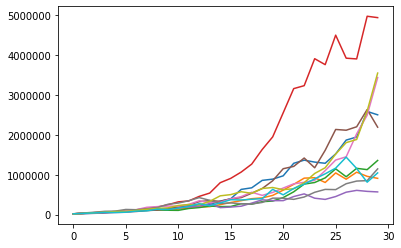

In [50]:
plt.plot(sim[first_ten])
plt.show()

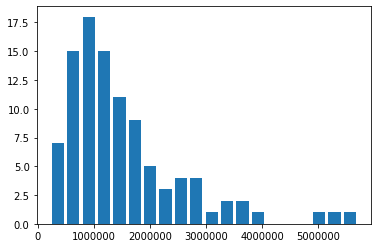

In [52]:
#Sim index values based on 30-1 years to account for Zero Index
ending_values = sim.loc[29]

plt.hist(ending_values, bins=20, rwidth=0.8)
plt.show()

In [53]:
p_tiles = np.percentile(ending_values,[5, 10, 15, 20, 25, 50, 75, 80, 85, 90, 95])

for p in range(len(p_tiles)):
    
    l = [5, 10, 15, 20, 25, 50, 75, 80, 85, 90, 95]
    print( "{}%-ile: ".format(l[p]).rjust(15),"{}".format(locale.currency(p_tiles[p], grouping=True)))

       5%-ile:  $399,387.89
      10%-ile:  $546,230.79
      15%-ile:  $634,739.83
      20%-ile:  $681,781.53
      25%-ile:  $817,975.89
      50%-ile:  $1,208,980.18
      75%-ile:  $1,852,765.87
      80%-ile:  $2,052,917.96
      85%-ile:  $2,505,928.37
      90%-ile:  $2,870,319.01
      95%-ile:  $3,557,965.39


In [60]:
# Calculate success rate

prob_of_success = len(ending_values[ending_values>4000000]) / len(ending_values)

f"The rate of success is {prob_of_success*100} %"

'The rate of success is 3.0 %'